In [77]:
import os, sys
dir1 = os.path.abspath(os.path.join(os.path.abspath(''), '..'))
if not dir1 in sys.path: sys.path.append(dir1)
from utils.environment import setup_data_vars
setup_data_vars()

In [78]:
import argparse

# define argparser for anatomy, and axis

parser = argparse.ArgumentParser(description='Inference for UniverSeg')

parser.add_argument('anatomy', type=str, help='The anatomy to infer on')
parser.add_argument('axis', type=str, help='The axis to infer on (0,1,2)')

args = parser.parse_args(
    ['Vagina', '1']
)

In [79]:
anatomy = args.anatomy # 'Anorectum'
support_size = 80
axis = int(args.axis) # 0
batch_size = 3

In [80]:
print(f'Infering on {anatomy} along axis {axis}')
print(f'Using support size {support_size} and batch size {batch_size}')

Infering on Vagina along axis 1
Using support size 80 and batch size 3


In [81]:
from torch.utils.data import Dataset
import random
import numpy as np
import cv2
import torch

class UniverSegDataSet(Dataset):
    def __init__(self, support_size, anatomy, axis):

        self.medsam_gts = os.path.join(os.environ.get('MedSAM_preprocessed_lowres'), 'gts', anatomy, f'axis{axis}')
        self.medsam_imgs = os.path.join(os.environ.get('MedSAM_preprocessed_lowres'), 'imgs', f'axis{axis}')

        self.support_size = support_size
        self.anatomy = anatomy
        self.axis = axis

        self.gts_samples = [f for f in sorted(os.listdir(self.medsam_gts)) if f.endswith('.npy')]

    def __len__(self):
        return len(self.gts_samples)
    
    def _read_image_and_gt(self, img_id, img_slice):
        img = np.load(os.path.join(self.medsam_imgs, f'CT_zzAMLART_{img_id:03d}-{img_slice:03d}.npy'))
        gt = np.load(os.path.join(self.medsam_gts, f'CT_{self.anatomy}_zzAMLART_{img_id:03d}-{img_slice:03d}.npy'))
        return img, gt
    
    def __getitem__(self, idx):
        ith_example = self.gts_samples[idx]

        # get a support set that doesn't contain the same id as the ith example
        get_id_from_img = lambda img_name: int(img_name.split('_')[3].split('-')[0])
        get_slice_from_img = lambda img_name: int(img_name.split('_')[3].split('-')[1].split('.')[0])

        ith_id = get_id_from_img(ith_example)
        ith_slice = get_slice_from_img(ith_example)

        support_set = random.sample([f for f in self.gts_samples if get_id_from_img(f) != ith_id], self.support_size)

        # read in the images and gts for the ith example and the support set and resize them appropriately
        ith_img, ith_gt = self._read_image_and_gt(ith_id, ith_slice)

        support_imgs = []
        support_gts = []

        for support_example in support_set:
            support_img, support_gt = self._read_image_and_gt(get_id_from_img(support_example), get_slice_from_img(support_example))

            support_imgs.append(support_img)
            support_gts.append(support_gt)

        # resize the images and gts to 128x128 we need for universeg

        ith_img = cv2.resize(ith_img, (128, 128), interpolation=cv2.INTER_LINEAR)
        ith_gt = cv2.resize(ith_gt, (128, 128), interpolation=cv2.INTER_NEAREST)

        support_imgs = [cv2.resize(support_img, (128, 128), interpolation=cv2.INTER_LINEAR) for support_img in support_imgs]
        support_gts = [cv2.resize(support_gt, (128, 128), interpolation=cv2.INTER_NEAREST) for support_gt in support_gts]

        # convert to torch tensors

        ith_img = torch.from_numpy(ith_img).float().unsqueeze(0)
        ith_gt = torch.from_numpy(ith_gt).float().unsqueeze(0)

        support_imgs = [torch.from_numpy(support_img).float().unsqueeze(0) for support_img in support_imgs]
        support_gts = [torch.from_numpy(support_gt).float().unsqueeze(0) for support_gt in support_gts]

        # stack the support images and gts
        support_imgs = torch.stack(support_imgs) # (S x 128 x 128)
        support_gts = torch.stack(support_gts) # (S x 128 x 128)

        assert support_imgs.shape == (self.support_size, 1, 128, 128), support_imgs.shape
        assert support_gts.shape == (self.support_size, 1, 128, 128), support_gts.shape
        assert ith_img.shape == (1, 128, 128), ith_img.shape
        assert ith_gt.shape == (1, 128, 128), ith_gt.shape

        return {
            'query_name': ith_example,
            'query': ith_img,
            'query_gt': ith_gt,
            'support_imgs': support_imgs,
            'support_gts': support_gts
        }

    def get_id_and_slice(self, id, slice_num):
        name = f'CT_zzAMLART_{id:03d}-{slice_num:03d}.npy'

        idx = self.gts_samples.index(name)

        return self.__getitem__(idx)


In [82]:
from torch.utils.data import DataLoader


# my_dataset = UniverSegDataSet(support_size=support_size, anatomy=anatomy, axis=axis)
# my_dataloder = DataLoader(my_dataset, batch_size=1, shuffle=True)

# # get a batch of data

# for i, batch in enumerate(my_dataloder):
#     print(batch['query'].shape)
#     print(batch['query_gt'].shape)
#     print(batch['support_imgs'].shape)
#     print(batch['support_gts'].shape)
#     break

In [83]:
from universeg import universeg
from platipy.imaging.label.comparison import compute_metric_total_apl, compute_surface_dsc, compute_metric_hd
import SimpleITK as sitk

dataset = UniverSegDataSet(support_size=support_size, anatomy=anatomy, axis=axis)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

In [84]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

overlap_measures_filter = sitk.LabelOverlapMeasuresImageFilter()

# Run the inference
model = universeg(pretrained=True)
model = model.to(device)

# load in parameters from the trained model
checkpoint = torch.load('results_finetuned/finetuning/model_checkpoint_best.pth')

model.load_state_dict(checkpoint['model'])

<All keys matched successfully>

In [106]:
from tqdm import tqdm

classes = ['Anorectum', 'Bladder', 'CTVn', 'CTVp', 'Parametrium', 'Uterus', 'Vagina']
axes = [0, 1, 2]

quantity = len(classes) * len(axes)

progress_bar = tqdm(classes, total=quantity)

for anatomy in progress_bar:
    for axis in axes:
        progress_bar.set_description(f'Setting up dataloader and getting batch')

        dataset = UniverSegDataSet(support_size=support_size, anatomy=anatomy, axis=axis)
        dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

        dataloader_iter = iter(dataloader)

        batch = next(dataloader_iter)

        progress_bar.set_description(f'Running inference on {names[0]}')

        names = batch['query_name']
        image = batch['query'].to(device)
        label = batch['query_gt']
        support_images = batch['support_imgs'].to(device)
        support_labels = batch['support_gts'].to(device)

        image = image.to(device)
        # label = label.to(device)
        support_images = support_images.to(device)
        support_labels = support_labels.to(device)

        prediction_logits = model(image, support_images, support_labels)
        prediction_soft = torch.sigmoid(prediction_logits)

        # threshold probabilities to get hard predictions
        prediction_hard = (prediction_soft > 0.5).float()

        progress_bar.set_description(f'Computing metrics for {anatomy} along axis {axis}')

        # for each batch of predictions, compute the metrics
        for j in range(prediction_hard.shape[0]):
            # compute the metrics
            prediction = prediction_hard[j].cpu().detach().numpy()
            prediction = sitk.GetImageFromArray(prediction)
            label_sitk = sitk.GetImageFromArray(label[j])

            prediction = sitk.Cast(prediction, sitk.sitkUInt8)
            label_sitk = sitk.Cast(label_sitk, sitk.sitkUInt8)

            overlap_measures_filter.Execute(label_sitk, prediction)

            dice = overlap_measures_filter.GetDiceCoefficient()
            hd = compute_metric_hd(label_sitk, prediction)
            volume_similarity = overlap_measures_filter.GetVolumeSimilarity()
            surface_dsc = compute_surface_dsc(label_sitk, prediction)
            apl = compute_metric_total_apl(label_sitk, prediction)

    progress_bar.set_description(f'Plotting and saving results for {anatomy} along axis {axis}')

    import matplotlib.pyplot as plt
    import numpy as np

    ncols = 3
    nrows = 1

    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*5, nrows*5))
    axs = axs.reshape(nrows, ncols)

    # show the image
    axs[0][0].imshow(image[0, 0].cpu().detach().numpy(), cmap='grey')
    axs[0][0].set_title('Query Image')
    axs[0][0].axis('off')

    # show the ground truth overlayed on the query image
    axs[0][1].imshow(image[0, 0].cpu().detach().numpy(), cmap='gray')
    axs[0][1].imshow(label[0, 0].cpu().detach().numpy(), alpha=label[0, 0].cpu().detach().numpy(), cmap='viridis')
    axs[0][1].set_title('Ground Truth')
    axs[0][1].axis('off')

    # show the prediction overlayed on the query image
    axs[0][2].imshow(image[0, 0].cpu().detach().numpy(), cmap='gray')
    axs[0][2].imshow(prediction_hard[0, 0].cpu().detach().numpy(), alpha=prediction_hard[0, 0].cpu().detach().numpy(), cmap='viridis')
    axs[0][2].set_title('Prediction')
    axs[0][2].axis('off')


    plt.tight_layout()
    plt.suptitle(f'Prediction of {anatomy} along axis {axis} ({names[0]}) with scores Dice: {dice:.2f}, HD: {hd:.2f}, Volume Similarity: {volume_similarity:.2f}, Surface DSC: {surface_dsc:.2f}, APL: {apl:.2f}', y=1.05)

    plt.savefig(f'results_finetuned/{anatomy}/axis{axis}/{names[0].split(".")[0]}.png', bbox_inches='tight')
    plt.clf()

    progress_bar.set_description(f'Finished {anatomy} along axis {axis}')
    # increment the progress_bar
    progress_bar.update(1)

  0%|          | 0/21 [00:10<?, ?it/s]


KeyboardInterrupt: 

In [91]:
anatomy = 'CTVn'
axis = '1'

dataset = UniverSegDataSet(support_size=support_size, anatomy=anatomy, axis=axis)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

In [92]:
dataloader_iter = iter(dataloader)

In [93]:
batch = next(dataloader_iter)

names = batch['query_name']
image = batch['query'].to(device)
label = batch['query_gt']
support_images = batch['support_imgs'].to(device)
support_labels = batch['support_gts'].to(device)

image = image.to(device)
# label = label.to(device)
support_images = support_images.to(device)
support_labels = support_labels.to(device)

prediction_logits = model(image, support_images, support_labels)
prediction_soft = torch.sigmoid(prediction_logits)

# threshold probabilities to get hard predictions
prediction_hard = (prediction_soft > 0.5).float()

# for each batch of predictions, compute the metrics
for j in range(prediction_hard.shape[0]):
    # compute the metrics
    prediction = prediction_hard[j].cpu().detach().numpy()
    prediction = sitk.GetImageFromArray(prediction)
    label_sitk = sitk.GetImageFromArray(label[j])

    prediction = sitk.Cast(prediction, sitk.sitkUInt8)
    label_sitk = sitk.Cast(label_sitk, sitk.sitkUInt8)

    overlap_measures_filter.Execute(label_sitk, prediction)

    dice = overlap_measures_filter.GetDiceCoefficient()
    hd = compute_metric_hd(label_sitk, prediction)
    volume_similarity = overlap_measures_filter.GetVolumeSimilarity()
    surface_dsc = compute_surface_dsc(label_sitk, prediction)
    apl = compute_metric_total_apl(label_sitk, prediction)

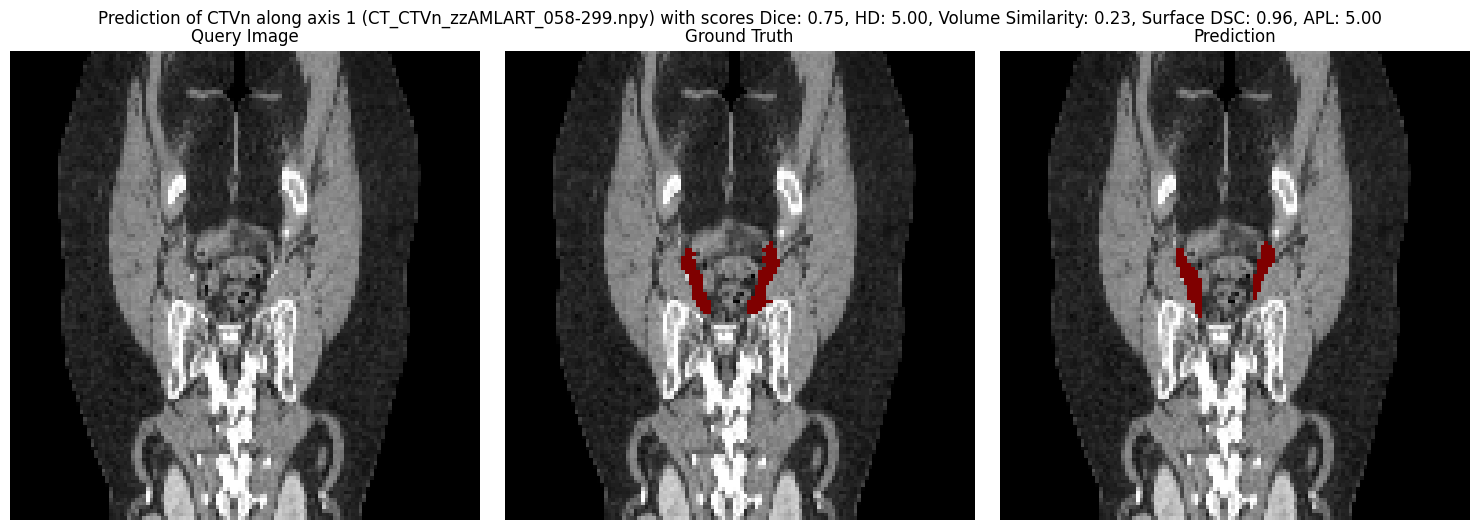

In [102]:
import matplotlib.pyplot as plt
import numpy as np

ncols = 3
nrows = 1

fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*5, nrows*5))
axs = axs.reshape(nrows, ncols)

# show the image
axs[0][0].imshow(image[0, 0].cpu().detach().numpy(), cmap='grey')
axs[0][0].set_title('Query Image')
axs[0][0].axis('off')

# show the ground truth overlayed on the query image
axs[0][1].imshow(image[0, 0].cpu().detach().numpy(), cmap='gray')
axs[0][1].imshow(label[0, 0].cpu().detach().numpy(), alpha=label[0, 0].cpu().detach().numpy(), cmap='jet')
axs[0][1].set_title('Ground Truth')
axs[0][1].axis('off')

# show the prediction overlayed on the query image
axs[0][2].imshow(image[0, 0].cpu().detach().numpy(), cmap='gray')
axs[0][2].imshow(prediction_hard[0, 0].cpu().detach().numpy(), alpha=prediction_hard[0, 0].cpu().detach().numpy(), cmap='viridis')
axs[0][2].set_title('Prediction')
axs[0][2].axis('off')


plt.tight_layout()
plt.suptitle(f'Prediction of {anatomy} along axis {axis} ({names[0]}) with scores Dice: {dice:.2f}, HD: {hd:.2f}, Volume Similarity: {volume_similarity:.2f}, Surface DSC: {surface_dsc:.2f}, APL: {apl:.2f}', y=1.05)

plt.savefig(f'results_finetuned/{anatomy}/axis{axis}/{names[0].split(".")[0]}.png', bbox_inches='tight')

<Figure size 640x480 with 0 Axes>

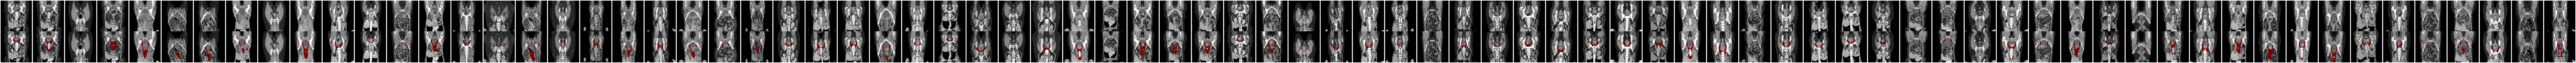

<Figure size 640x480 with 0 Axes>

In [104]:
# plot the support set

ncols = support_size
nrows = 2

fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*5, nrows*5))
axs = axs.reshape(nrows, ncols)

for i in range(support_size):
    axs[0][i].imshow(support_images[0, i, 0].cpu().detach().numpy(), cmap='gray')
    axs[0][i].axis('off')

    axs[1][i].imshow(support_images[0, i, 0].cpu().detach().numpy(), cmap='gray')
    axs[1][i].imshow(support_labels[0, i, 0].cpu().detach().numpy(), alpha=support_labels[0, i, 0].cpu().detach().numpy(), cmap='viridis')
    axs[1][i].axis('off')

plt.tight_layout()
plt.suptitle('Support Set')
plt.show()

plt.savefig(f'results_finetuned/{anatomy}/axis{axis}/{names[0].split(".")[0]}-support.png', bbox_inches='tight')